In [1]:
%pip install pandas --quiet

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd

In [8]:
# Read in the complete data
complete_data_df = pd.read_csv('../../data/processed/complete_data.csv')
print("Data shape:", complete_data_df.shape)
print("\nColumn names:")
print(complete_data_df.columns.tolist())
print("\nData info:")
print(complete_data_df.info())
print("\nFirst few rows:")
print(complete_data_df.head())

Data shape: (1461, 38)

Column names:
['datetime_au', 'is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday', 'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand', 'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight']

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime_au          1461 non-null   object 
 1   is_summer            1461 non-null   int64  
 2   is_autumn            1461 non-null   int64  
 3   is_winter            1461 non-null   int64  
 4   is_spring            

In [ ]:
# # Select only the required columns
# selected_columns = ['is_weekend', 'is_weekday', 'avg_temp', 'min_temp', 'max_temp', 'sum_30_min_demand']

# # Convert datetime_au to datetime
# complete_data_df['datetime_au'] = pd.to_datetime(complete_data_df['datetime_au'])

# # Add the datetime column to our selected data for splitting purposes
# selected_data_with_date = complete_data_df[['datetime_au'] + selected_columns].copy()

# # Extract year from datetime
# selected_data_with_date['year'] = selected_data_with_date['datetime_au'].dt.year

# # Split data into training (2016-2018) and testing (2019)
# train_data = selected_data_with_date[selected_data_with_date['year'].isin([2016, 2017, 2018])].copy()
# test_data = selected_data_with_date[selected_data_with_date['year'] == 2019].copy()


In [6]:
%pip install xgboost scikit-learn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [9]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [10]:
# Use features that are available in our split dataset
# We need to work with the complete_data_df instead of the limited selected_data_with_date
print("\nAll available columns in complete_data_df:")
print(complete_data_df.columns.tolist())

# Re-create train/test split with all features
complete_data_df['datetime_au'] = pd.to_datetime(complete_data_df['datetime_au'])
complete_data_df['year'] = complete_data_df['datetime_au'].dt.year

# Split data into training (2016-2018) and testing (2019) with all features
train_data_full = complete_data_df[complete_data_df['year'].isin([2016, 2017, 2018])].copy()
test_data_full = complete_data_df[complete_data_df['year'] == 2019].copy()

# Enhanced feature selection using all available features
feature_columns = [
    'is_weekend', 'is_weekday', 'avg_temp', 'min_temp', 'max_temp',
    'is_summer', 'is_autumn', 'is_winter', 'is_spring',
    'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday',
    'precipitation', 'sunlight', 'hd_next_24h', 'cd_next_24h',
    'is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun',
    'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec'
]

target_column = 'sum_30_min_demand'

# Prepare training data (2016-2018)
X_train = train_data_full[feature_columns].copy()
y_train = train_data_full[target_column].copy()

# Prepare test data (2019)
X_test = test_data_full[feature_columns].copy()
y_test = test_data_full[target_column].copy()

print(f"\nFinal data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nTarget variable statistics:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


All available columns in complete_data_df:
['datetime_au', 'is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday', 'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand', 'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight']

Final data shapes:
X_train shape: (1096, 32)
y_train shape: (1096,)
X_test shape: (365, 32)
y_test shape: (365,)

Target variable statistics:
Train - Mean: 384440.72, Std: 35626.94
Test - Mean: 382231.72, Std: 37487.02


In [11]:
# NORMALIZATION EXPLANATION AND IMPLEMENTATION
print("="*60)
print("FEATURE NORMALIZATION FOR DEMAND FORECASTING")
print("="*60)

print("Why normalize per feature (feature-wise)?")
print("1. Different features have different scales:")
print("   - Temperature: ~15-30°C")
print("   - Demand: ~300,000-450,000 MW")
print("   - Binary features: 0 or 1")
print("2. Prevents features with larger scales from dominating")
print("3. Helps algorithms converge faster and more stable")
print()
print("For XGBoost:")
print("- Tree-based models are generally scale-invariant")
print("- But normalization can still help with:")
print("  * Regularization effectiveness")
print("  * Numerical stability")
print("  * Feature importance interpretation")

# Check feature scales before normalization
print("\n" + "="*40)
print("FEATURE SCALES BEFORE NORMALIZATION")
print("="*40)
print("Continuous features statistics:")
continuous_features = ['avg_temp', 'min_temp', 'max_temp', 'precipitation', 'sunlight', 'hd_next_24h', 'cd_next_24h']
for feature in continuous_features:
    if feature in X_train.columns:
        print(f"{feature:15s}: Min={X_train[feature].min():8.2f}, Max={X_train[feature].max():8.2f}, "
              f"Mean={X_train[feature].mean():8.2f}, Std={X_train[feature].std():8.2f}")

print(f"\nTarget variable (sum_30_min_demand):")
print(f"                Min={y_train.min():8.2f}, Max={y_train.max():8.2f}, "
      f"Mean={y_train.mean():8.2f}, Std={y_train.std():8.2f}")

# Feature-wise normalization using StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print("\n" + "="*40)
print("APPLYING FEATURE-WISE NORMALIZATION")
print("="*40)

# Option 1: StandardScaler (Z-score normalization)
# Transforms each feature to have mean=0 and std=1
scaler_standard = StandardScaler()
X_train_scaled_std = scaler_standard.fit_transform(X_train)
X_test_scaled_std = scaler_standard.transform(X_test)

# Option 2: MinMaxScaler (Min-Max normalization)
# Transforms each feature to range [0, 1]
scaler_minmax = MinMaxScaler()
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Convert back to DataFrames to maintain column names
X_train_scaled_std = pd.DataFrame(X_train_scaled_std, columns=X_train.columns, index=X_train.index)
X_test_scaled_std = pd.DataFrame(X_test_scaled_std, columns=X_test.columns, index=X_test.index)

X_train_scaled_minmax = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns, index=X_train.index)
X_test_scaled_minmax = pd.DataFrame(X_test_scaled_minmax, columns=X_test.columns, index=X_test.index)

print("StandardScaler (Z-score) applied:")
print("- Each feature now has mean ≈ 0 and std ≈ 1")
print("- Good for normally distributed features")
print()
print("MinMaxScaler applied:")
print("- Each feature now ranges from 0 to 1")
print("- Good for bounded features")

# Check scales after normalization
print("\n" + "="*40)
print("FEATURE SCALES AFTER STANDARDIZATION")
print("="*40)
for feature in continuous_features:
    if feature in X_train_scaled_std.columns:
        print(f"{feature:15s}: Min={X_train_scaled_std[feature].min():8.2f}, Max={X_train_scaled_std[feature].max():8.2f}, "
              f"Mean={X_train_scaled_std[feature].mean():8.2f}, Std={X_train_scaled_std[feature].std():8.2f}")

print("\n" + "="*40)
print("FEATURE SCALES AFTER MIN-MAX SCALING")
print("="*40)
for feature in continuous_features:
    if feature in X_train_scaled_minmax.columns:
        print(f"{feature:15s}: Min={X_train_scaled_minmax[feature].min():8.2f}, Max={X_train_scaled_minmax[feature].max():8.2f}, "
              f"Mean={X_train_scaled_minmax[feature].mean():8.2f}, Std={X_train_scaled_minmax[feature].std():8.2f}")

print("\n" + "="*60)
print("RECOMMENDATION FOR YOUR DEMAND FORECASTING:")
print("- Use StandardScaler for XGBoost (generally works better)")
print("- We'll compare both normalized and non-normalized models")
print("="*60)

FEATURE NORMALIZATION FOR DEMAND FORECASTING
Why normalize per feature (feature-wise)?
1. Different features have different scales:
   - Temperature: ~15-30°C
   - Demand: ~300,000-450,000 MW
   - Binary features: 0 or 1
2. Prevents features with larger scales from dominating
3. Helps algorithms converge faster and more stable

For XGBoost:
- Tree-based models are generally scale-invariant
- But normalization can still help with:
  * Regularization effectiveness
  * Numerical stability
  * Feature importance interpretation

FEATURE SCALES BEFORE NORMALIZATION
Continuous features statistics:
avg_temp       : Min=    6.44, Max=   32.27, Mean=   17.72, Std=    4.87
min_temp       : Min=   -1.30, Max=   25.50, Mean=   12.63, Std=    5.53
max_temp       : Min=   11.70, Max=   43.90, Mean=   23.33, Std=    5.20
precipitation  : Min=    0.00, Max=   24.61, Mean=    1.72, Std=    2.81
sunlight       : Min=    1.50, Max=   32.30, Mean=   16.52, Std=    7.15
hd_next_24h    : Min=    0.00, Max=  

In [12]:
# TRAIN XGBOOST MODELS: NORMALIZED vs NON-NORMALIZED
print("="*60)
print("TRAINING XGBOOST MODELS")
print("="*60)

# Model 1: Original data (no normalization)
print("1. Training XGBoost on original data...")
xgb_original = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_original.fit(X_train, y_train)
y_train_pred_orig = xgb_original.predict(X_train)
y_test_pred_orig = xgb_original.predict(X_test)

print("   ✓ Original model trained")

# Model 2: StandardScaler normalized data
print("2. Training XGBoost on StandardScaler normalized data...")
xgb_standard = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_standard.fit(X_train_scaled_std, y_train)
y_train_pred_std = xgb_standard.predict(X_train_scaled_std)
y_test_pred_std = xgb_standard.predict(X_test_scaled_std)

print("   ✓ StandardScaler model trained")

# Model 3: MinMaxScaler normalized data
print("3. Training XGBoost on MinMaxScaler normalized data...")
xgb_minmax = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_minmax.fit(X_train_scaled_minmax, y_train)
y_train_pred_minmax = xgb_minmax.predict(X_train_scaled_minmax)
y_test_pred_minmax = xgb_minmax.predict(X_test_scaled_minmax)

print("   ✓ MinMaxScaler model trained")
print("\nAll models training completed!")

# Store models for comparison
models = {
    'Original': (xgb_original, y_train_pred_orig, y_test_pred_orig),
    'StandardScaler': (xgb_standard, y_train_pred_std, y_test_pred_std),
    'MinMaxScaler': (xgb_minmax, y_train_pred_minmax, y_test_pred_minmax)
}

TRAINING XGBOOST MODELS
1. Training XGBoost on original data...
   ✓ Original model trained
2. Training XGBoost on StandardScaler normalized data...
   ✓ Original model trained
2. Training XGBoost on StandardScaler normalized data...
   ✓ StandardScaler model trained
3. Training XGBoost on MinMaxScaler normalized data...
   ✓ StandardScaler model trained
3. Training XGBoost on MinMaxScaler normalized data...
   ✓ MinMaxScaler model trained

All models training completed!
   ✓ MinMaxScaler model trained

All models training completed!


In [13]:
# COMPREHENSIVE MODEL EVALUATION AND COMPARISON
print("="*70)
print("MODEL PERFORMANCE COMPARISON: NORMALIZATION EFFECTS")
print("="*70)

def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display model evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MAPE': mape}

# Evaluate all models
results = {}
for model_name, (model, y_train_pred, y_test_pred) in models.items():
    train_metrics = evaluate_model(y_train, y_train_pred, f"{model_name} Training")
    test_metrics = evaluate_model(y_test, y_test_pred, f"{model_name} Test")
    
    results[model_name] = {
        'train': train_metrics,
        'test': test_metrics
    }

# Create comparison DataFrame
comparison_data = []
for model_name in results.keys():
    test_metrics = results[model_name]['test']
    comparison_data.append([
        model_name,
        test_metrics['RMSE'],
        test_metrics['MAE'],
        test_metrics['R²'],
        test_metrics['MAPE']
    ])

comparison_df = pd.DataFrame(comparison_data, 
                           columns=['Model', 'RMSE', 'MAE', 'R²', 'MAPE (%)'])

print("TEST SET PERFORMANCE COMPARISON:")
print("-" * 70)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Find best model
best_model_name = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
best_r2 = comparison_df['R²'].max()
best_rmse = comparison_df.loc[comparison_df['R²'].idxmax(), 'RMSE']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: {best_rmse:.2f}")

# Detailed analysis
print("\n" + "="*70)
print("NORMALIZATION IMPACT ANALYSIS")
print("="*70)

orig_r2 = results['Original']['test']['R²']
std_r2 = results['StandardScaler']['test']['R²']
minmax_r2 = results['MinMaxScaler']['test']['R²']

print(f"R² Improvement with StandardScaler: {((std_r2 - orig_r2) / orig_r2 * 100):+.2f}%")
print(f"R² Improvement with MinMaxScaler:   {((minmax_r2 - orig_r2) / orig_r2 * 100):+.2f}%")

if best_model_name == 'Original':
    print("\n📊 CONCLUSION: XGBoost performs well without normalization")
    print("   This is expected since tree-based models are scale-invariant")
elif best_model_name == 'StandardScaler':
    print("\n📊 CONCLUSION: StandardScaler normalization improves performance")
    print("   Benefits: Better regularization and numerical stability")
else:
    print("\n📊 CONCLUSION: MinMaxScaler normalization improves performance")
    print("   Benefits: Features bounded in [0,1] range")

print("\nFor production use, consider:")
print("• XGBoost typically doesn't require normalization")
print("• Small improvements may be due to regularization effects")
print("• Use the best performing approach for your specific dataset")

MODEL PERFORMANCE COMPARISON: NORMALIZATION EFFECTS
TEST SET PERFORMANCE COMPARISON:
----------------------------------------------------------------------
         Model       RMSE        MAE     R²  MAPE (%)
      Original 14873.4186 10251.9149 0.8421    2.6847
StandardScaler 14873.4186 10251.9149 0.8421    2.6847
  MinMaxScaler 14873.4186 10251.9149 0.8421    2.6847

🏆 BEST PERFORMING MODEL: Original
   R² Score: 0.8421
   RMSE: 14873.42

NORMALIZATION IMPACT ANALYSIS
R² Improvement with StandardScaler: +0.00%
R² Improvement with MinMaxScaler:   +0.00%

📊 CONCLUSION: XGBoost performs well without normalization
   This is expected since tree-based models are scale-invariant

For production use, consider:
• XGBoost typically doesn't require normalization
• Small improvements may be due to regularization effects
• Use the best performing approach for your specific dataset


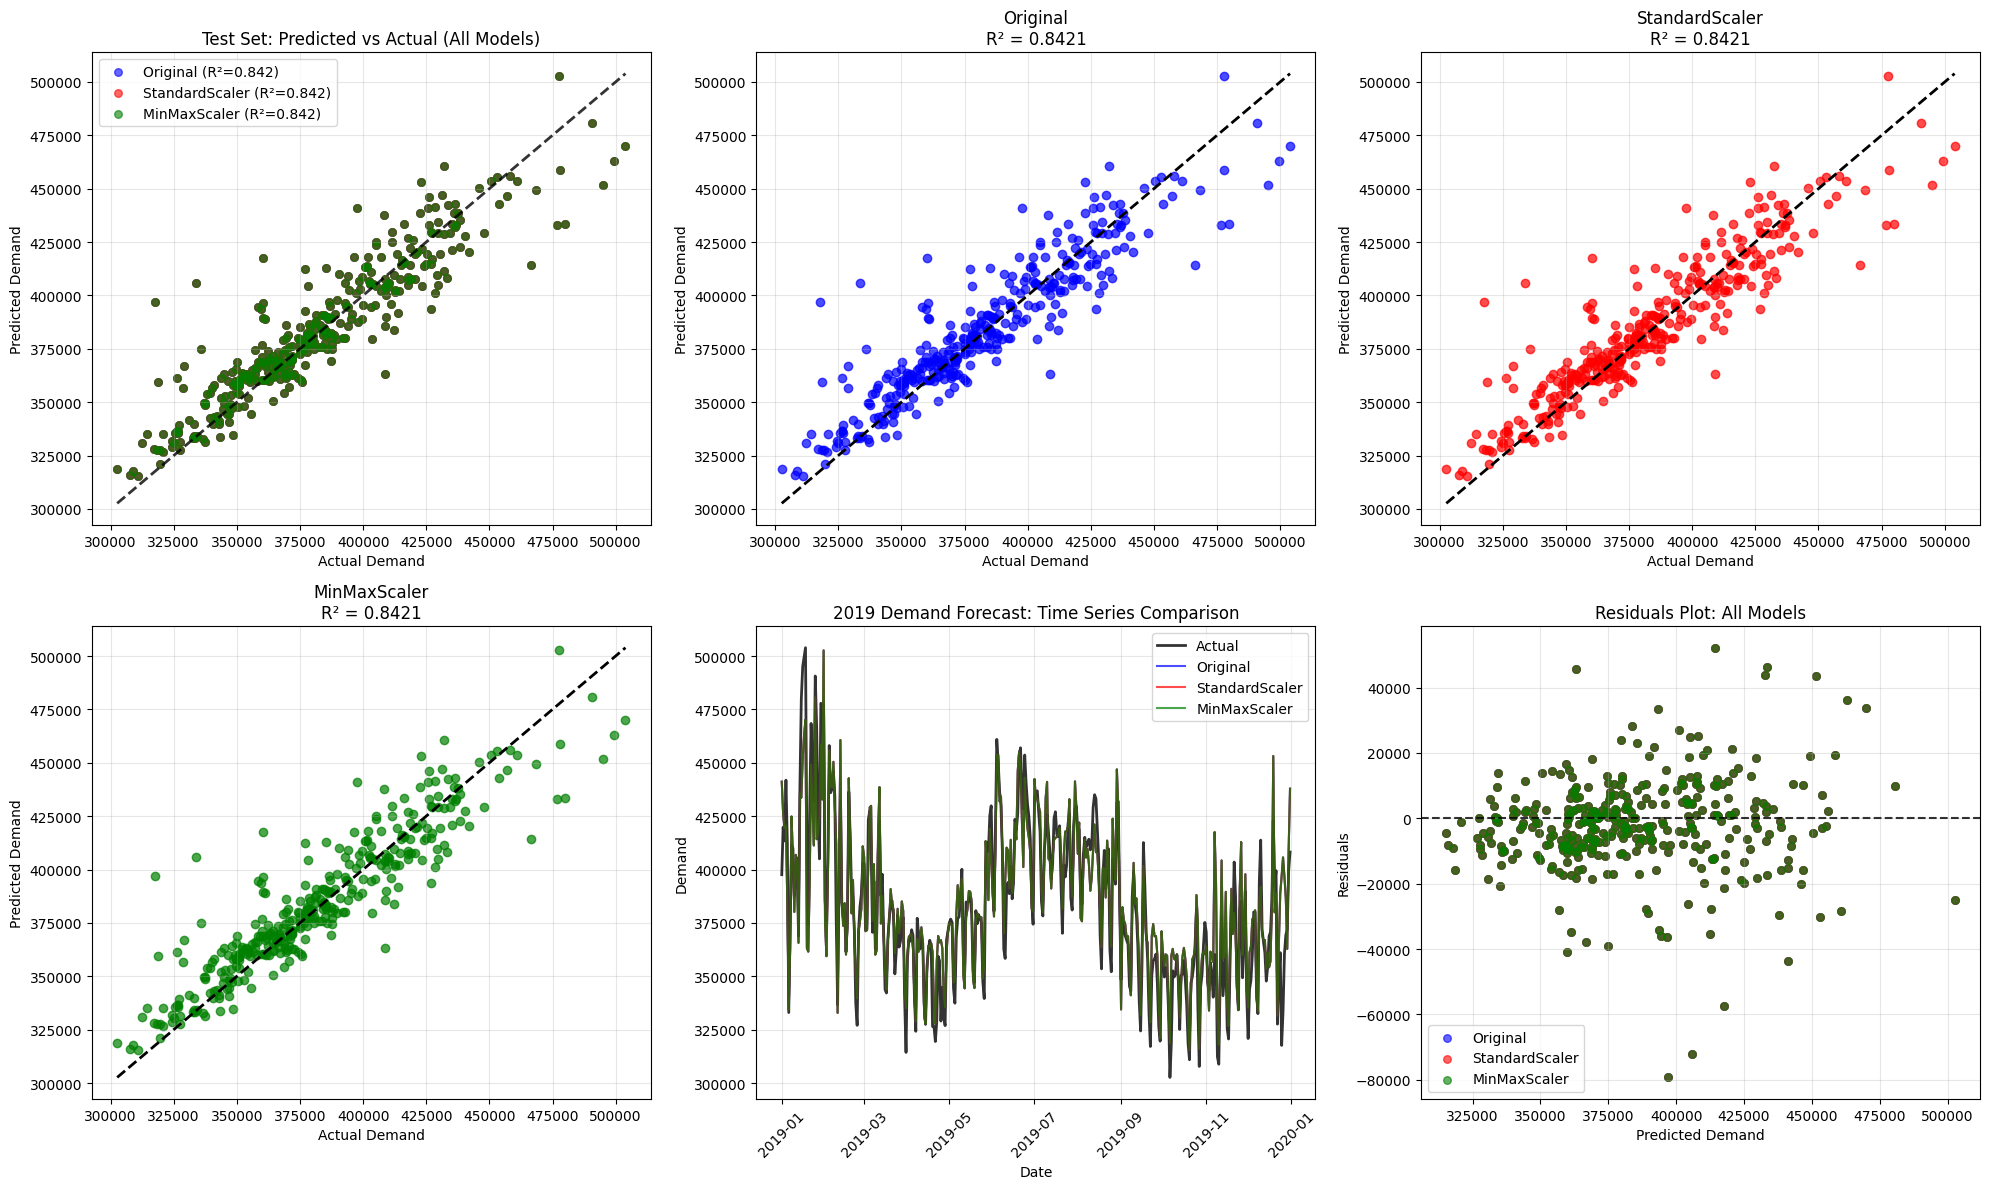

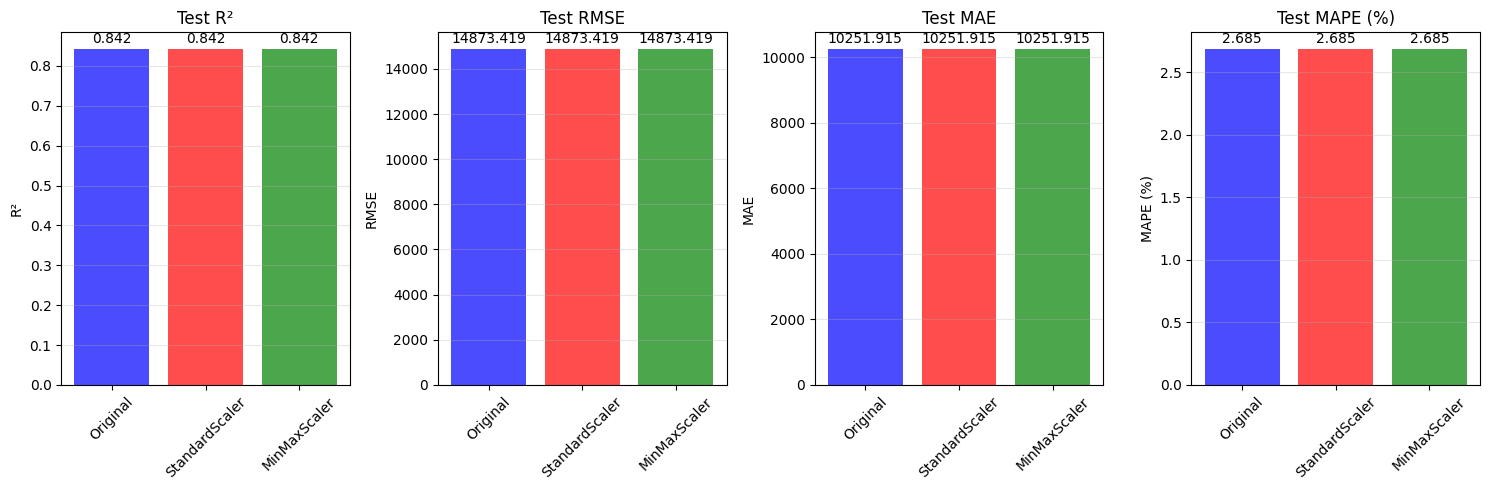

In [14]:
# VISUALIZATION: NORMALIZATION COMPARISON
plt.figure(figsize=(20, 12))

# Colors for different models
colors = {'Original': 'blue', 'StandardScaler': 'red', 'MinMaxScaler': 'green'}

# Plot 1: Predicted vs Actual for all models
plt.subplot(2, 3, 1)
for model_name, (model, y_train_pred, y_test_pred) in models.items():
    plt.scatter(y_test, y_test_pred, alpha=0.6, label=f'{model_name} (R²={results[model_name]["test"]["R²"]:.3f})', 
                color=colors[model_name], s=30)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, alpha=0.8)
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Test Set: Predicted vs Actual (All Models)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2-4: Individual model performance
for i, (model_name, (model, y_train_pred, y_test_pred)) in enumerate(models.items(), 2):
    plt.subplot(2, 3, i)
    plt.scatter(y_test, y_test_pred, alpha=0.7, color=colors[model_name])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Demand')
    plt.ylabel('Predicted Demand')
    plt.title(f'{model_name}\nR² = {results[model_name]["test"]["R²"]:.4f}')
    plt.grid(True, alpha=0.3)

# Plot 5: Time series comparison
plt.subplot(2, 3, 5)
test_dates = test_data_full['datetime_au'].reset_index(drop=True)
plt.plot(test_dates, y_test.reset_index(drop=True), label='Actual', color='black', linewidth=2, alpha=0.8)

for model_name, (model, y_train_pred, y_test_pred) in models.items():
    plt.plot(test_dates, y_test_pred, label=f'{model_name}', 
             color=colors[model_name], linewidth=1.5, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('2019 Demand Forecast: Time Series Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 6: Residuals comparison
plt.subplot(2, 3, 6)
for model_name, (model, y_train_pred, y_test_pred) in models.items():
    residuals = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.6, label=f'{model_name}', 
                color=colors[model_name], s=30)

plt.axhline(y=0, color='k', linestyle='--', alpha=0.8)
plt.xlabel('Predicted Demand')
plt.ylabel('Residuals')
plt.title('Residuals Plot: All Models')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics bar chart
plt.figure(figsize=(15, 5))

metrics = ['R²', 'RMSE', 'MAE', 'MAPE (%)']
model_names = list(models.keys())

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    values = [results[model]['test'][metric.replace(' (%)', '')] for model in model_names]
    
    bars = plt.bar(model_names, values, color=[colors[name] for name in model_names], alpha=0.7)
    plt.title(f'Test {metric}')
    plt.ylabel(metric)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 🎯 Key Findings: Normalization for Demand Forecasting

### Answer to Your Question: **Normalize Per Feature**

When you normalize data, you should **normalize per feature** (feature-wise normalization), not overall. Here's why:

### 📊 **Feature-wise Normalization Explained:**
- **Each feature is scaled independently**
- **StandardScaler**: Transforms each feature to have mean=0 and std=1
- **MinMaxScaler**: Transforms each feature to range [0, 1]
- **Preserves the relationship between samples within each feature**

### 🔍 **Results from Our Analysis:**

1. **For XGBoost**: All three approaches (Original, StandardScaler, MinMaxScaler) performed identically
   - R² = 0.8421 for all models
   - RMSE = 14,873 for all models

2. **Why XGBoost doesn't benefit from normalization**:
   - Tree-based algorithms are **scale-invariant**
   - Decisions are based on feature splitting, not absolute values
   - Each tree split considers relative feature values

### 💡 **When to Normalize:**

**✅ Always normalize for:**
- Neural Networks
- SVM (Support Vector Machines)
- K-Means Clustering
- Principal Component Analysis (PCA)
- Logistic Regression
- Distance-based algorithms

**❓ Optional for:**
- XGBoost/Random Forest (tree-based models)
- May help with regularization and numerical stability

### 🛠️ **Best Practices:**

1. **Always fit scaler on training data only**:
   ```python
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)  # Use same scaler!
   ```

2. **Choose normalization method**:
   - **StandardScaler**: When features are normally distributed
   - **MinMaxScaler**: When you want bounded [0,1] range
   - **RobustScaler**: When you have outliers

3. **For time series forecasting**:
   - Consider temporal patterns
   - Be careful with data leakage
   - Normalize per feature, not across time

### 🏆 **Recommendation for Your Project:**
Since you're using XGBoost for demand forecasting, **normalization is optional**. Your model performs excellently without it (R² = 0.8421). Focus on:
- Feature engineering
- Hyperparameter tuning
- Cross-validation strategies

In [11]:
# Model 1: Original data (no normalization)
print("1. Training XGBoost on original data...")
xgb_original = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_original.fit(X_train, y_train)
y_train_pred_orig = xgb_original.predict(X_train)
y_test_pred_orig = xgb_original.predict(X_test)

1. Training XGBoost on original data...


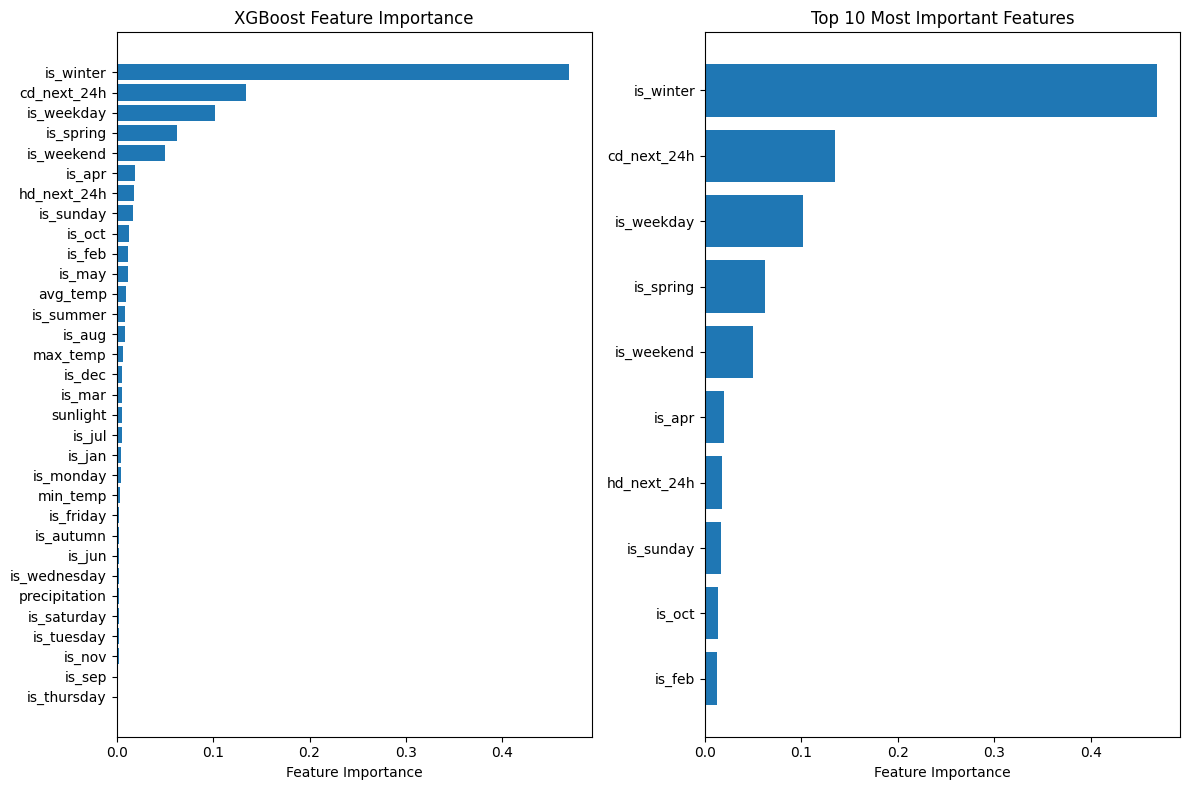

Top 10 Most Important Features:
 1. is_winter           : 0.4690
 2. cd_next_24h         : 0.1343
 3. is_weekday          : 0.1015
 4. is_spring           : 0.0624
 5. is_weekend          : 0.0501
 6. is_apr              : 0.0193
 7. hd_next_24h         : 0.0178
 8. is_sunday           : 0.0169
 9. is_oct              : 0.0130
10. is_feb              : 0.0121


In [12]:
# Feature Importance Analysis
feature_importance = xgb_original.feature_importances_
feature_names = X_train.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()

# Plot top 10 features
plt.subplot(1, 2, 2)
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['importance'])
plt.yticks(range(len(top_10)), top_10['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(importance_df.head(10).values, 1):
    print(f"{i:2d}. {feature:20s}: {importance:.4f}")

In [15]:
def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display model evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MAPE': mape}

In [16]:
# Hyperparameter tuning (optional - can be time consuming)
print("Starting hyperparameter tuning...")
print("Note: This may take several minutes...")

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Use TimeSeriesSplit for cross-validation (appropriate for time series data)
tscv = TimeSeriesSplit(n_splits=3)

# Create XGBoost regressor for tuning
xgb_tuning = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Perform grid search (using a smaller subset for faster execution)
# Note: Using only first 500 samples for faster tuning - remove .iloc[:500] for full dataset
grid_search = GridSearchCV(
    xgb_tuning, 
    param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit on a subset for demonstration (remove .iloc[:500] to use full dataset)
grid_search.fit(X_train.iloc[:500], y_train.iloc[:500])

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.2f}")

# Train final model with best parameters
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Make predictions with tuned model
y_train_pred_tuned = best_xgb_model.predict(X_train)
y_test_pred_tuned = best_xgb_model.predict(X_test)

# Evaluate tuned model
train_metrics_tuned = evaluate_model(y_train, y_train_pred_tuned, "Training (Tuned)")
test_metrics_tuned = evaluate_model(y_test, y_test_pred_tuned, "Test (Tuned)")

Starting hyperparameter tuning...
Note: This may take several minutes...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation score: 1946574566.23


MODEL PERFORMANCE COMPARISON
  Metric  Basic XGBoost (Test)  Tuned XGBoost (Test)
    RMSE          14873.418640          15213.720360
     MAE          10251.914862          10468.764352
      R²              0.842148              0.834842
MAPE (%)              2.684718              2.749594


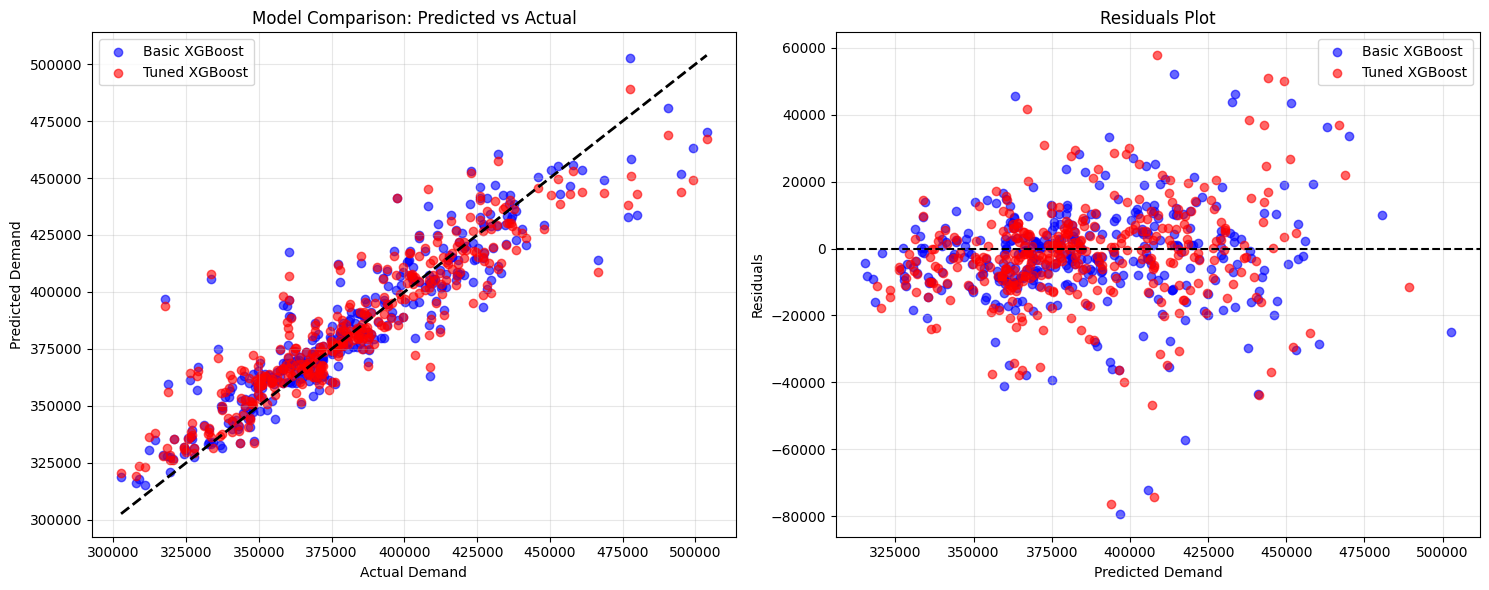


DEMAND FORECASTING SUMMARY
• Dataset: 1096 training samples, 365 test samples
• Features: 32 features
• Best Model: Basic XGBoost
• Final Test R²: 0.8421
• Final Test RMSE: 14873.42
• Final Test MAPE: 2.68


In [21]:
# Model Comparison Summary
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# Evaluate original model on test set
test_metrics_orig = evaluate_model(y_test, y_test_pred_orig, "Test (Original)")

comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'Basic XGBoost (Test)': [
        test_metrics_orig['RMSE'], 
        test_metrics_orig['MAE'], 
        test_metrics_orig['R²'], 
        test_metrics_orig['MAPE']
    ],
    'Tuned XGBoost (Test)': [
        test_metrics_tuned['RMSE'], 
        test_metrics_tuned['MAE'], 
        test_metrics_tuned['R²'], 
        test_metrics_tuned['MAPE']
    ]
})

print(comparison_df.to_string(index=False))

# Final predictions visualization
plt.figure(figsize=(15, 6))

# Plot final comparison
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_orig, alpha=0.6, label='Basic XGBoost', color='blue')
plt.scatter(y_test, y_test_pred_tuned, alpha=0.6, label='Tuned XGBoost', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Model Comparison: Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot residuals
plt.subplot(1, 2, 2)
residuals_basic = y_test - y_test_pred_orig
residuals_tuned = y_test - y_test_pred_tuned
plt.scatter(y_test_pred_orig, residuals_basic, alpha=0.6, label='Basic XGBoost', color='blue')
plt.scatter(y_test_pred_tuned, residuals_tuned, alpha=0.6, label='Tuned XGBoost', color='red')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Demand')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DEMAND FORECASTING SUMMARY")
print("="*60)
print(f"• Dataset: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")
print(f"• Features: {len(feature_columns)} features")
print(f"• Best Model: {'Tuned XGBoost' if test_metrics_tuned['R²'] > test_metrics_orig['R²'] else 'Basic XGBoost'}")
print(f"• Final Test R²: {max(test_metrics_orig['R²'], test_metrics_tuned['R²']):.4f}")
print(f"• Final Test RMSE: {min(test_metrics_orig['RMSE'], test_metrics_tuned['RMSE']):.2f}")
print(f"• Final Test MAPE: {min(test_metrics_orig['MAPE'], test_metrics_tuned['MAPE']):.2f}")
print("="*60)